In [77]:
# Importa las librerias requeridas para el proyecto
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sionna

In [78]:
# Parametros del sistema
N = 1024 # longitud del código
K = 512 # número de bits de información (antes de CRC)
EBNO_DB_MIN = 0
EBNO_DB_MAX = 15
LOTE = 100 # tamaño del lote

In [79]:
# Generador 'dummy' de bits congelados
import csv

digits = np.random.permutation(N)[:(N-K)]
with open('random_digits.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(digits)
bits_congelados = np.loadtxt('random_digits.csv', delimiter=',', dtype=int)

In [88]:
class CodPolarCanalAWGN(sionna.phy.Block):
    def __init__(self, N, K, bits_congelados, CRC_tipo="CRC24A", lista_SCL=8, bitsxsimb=4):
        super().__init__()
        self.N = N
        self.K = K
        self.K_datos = K - 24  # Asumiendo CRC24A
        self.bits_congelados = bits_congelados
        self.CRC_tipo = CRC_tipo
        self.lista_SCL = lista_SCL
        self.bitsxsimb = bitsxsimb
        
        # Inicializa los bloques necesarios
        self.datos = sionna.phy.mapping.BinarySource()
        self.CRC_codif = sionna.phy.fec.crc.CRCEncoder(CRC_tipo)
        self.polar_codif = sionna.phy.fec.polar.encoding.PolarEncoder(bits_congelados, N)
        self.constelacion = sionna.phy.mapping.Constellation("qam", bitsxsimb)
        self.mapeador = sionna.phy.mapping.Mapper(constellation=self.constelacion)
        self.demapeador = sionna.phy.mapping.Demapper("app", constellation=self.constelacion)
        self.awgn = sionna.phy.channel.AWGN()
        self.polar_decodif = sionna.phy.fec.polar.decoding.PolarSCLDecoder(bits_congelados, N, list_size=lista_SCL)
        self.CRC_decodif = sionna.phy.fec.crc.CRCDecoder(crc_encoder=self.CRC_codif)
    
    def call(self, batch_size, ebno_db):
        # Codificación
        b = self.datos([batch_size, self.K_datos])
        data_con_crc = self.CRC_codif(b)
        bits_codif = self.polar_codif(data_con_crc)

        # Mapeo
        x = self.mapeador(bits_codif)
        
        # Canal AWGN
        no = sionna.phy.utils.ebnodb2no(ebno_db, self.bitsxsimb, coderate=self.K/self.N)
        y = self.awgn(x, no)
        
        # Demapeo
        llr = self.demapeador(y, no)
        
        # Decodificación
        words_decodif = self.polar_decodif(llr)
        b_hat, crc_ok = self.CRC_decodif(words_decodif)
        
        return b_hat, b, llr, crc_ok

In [ ]:
sistema = CodPolarCanalAWGN(N, K, bits_congelados)
b_hat, b, llr, crc_ok = sistema(LOTE, EBNO_DB_MAX)
# print(b.shape)  # debería ser (1, 488)
# print(b_hat.shape)  # debería ser (1, 488)
# print(crc_ok)  # debería ser True

/home/sergio/miniconda3/envs/tf/lib/python3.12/site-packages/sionna/phy/fec/polar/decoding.py:415: UserWarning: Required resource allocation is large for the selected blocklength. Consider option `cpu_only=True`.
  warnings.warn("Required resource allocation is large " \


(100, 488)
(100, 488)
tf.Tensor(
[[ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]], shape=(100, 1), dtype=bool)


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 4.9771e-01 | 1.0000e+00 |      121441 |      244000 |          500 |         500 |        56.8 |reached target block errors
    1.071 | 4.9661e-01 | 1.0000e+00 |      121173 |      244000 |          500 |         500 |        58.6 |reached target block errors
    2.143 | 4.9554e-01 | 1.0000e+00 |      120912 |      244000 |          500 |         500 |        59.6 |reached target block errors
    3.214 | 4.9066e-01 | 1.0000e+00 |      119722 |      244000 |          500 |         500 |        59.9 |reached target block errors
    4.286 | 4.8909e-01 | 1.0000e+00 |      119339 |      244000 |          500 |         500 |        61.7 |reached target block errors
    5.357 | 4.8635e-01 | 1.0000e+00 |      118670 |      244000 |

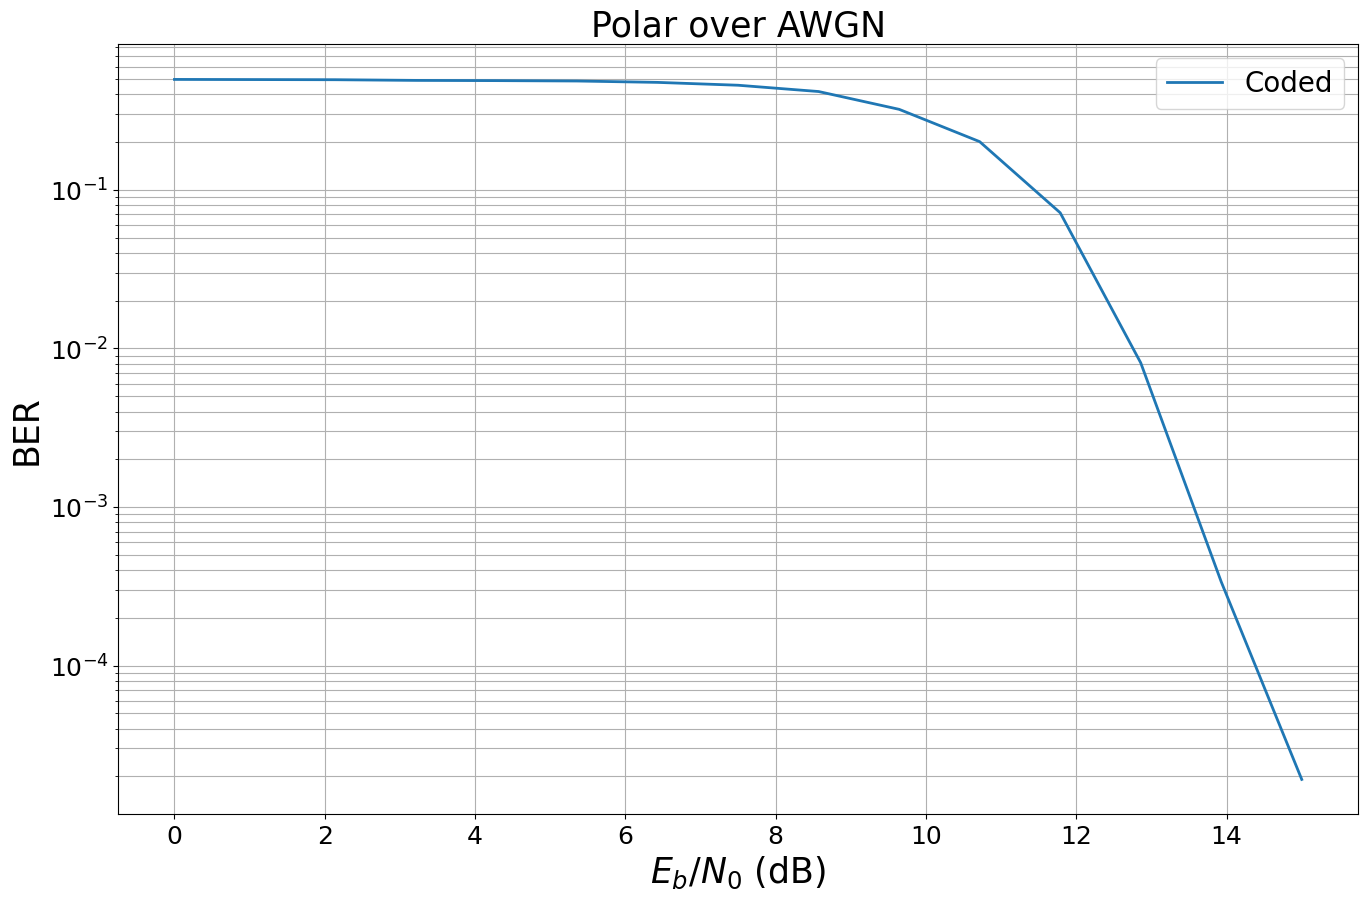

In [90]:
ber_plots = sionna.phy.utils.PlotBER("Polar over AWGN")
ber_plots.simulate(sistema,
                   ebno_dbs=np.linspace(EBNO_DB_MIN, EBNO_DB_MAX, 15),
                   batch_size=LOTE,
                   num_target_block_errors=500,
                   legend="Coded",
                   soft_estimates=False,
                   max_mc_iter=15,
                   show_fig=True,
                   forward_keyboard_interrupt=False);